In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader


In [3]:
DATA_DIR = "/kaggle/input/braintumor-cv/BrainTumor_cv"

IMG_TRAIN = os.path.join(DATA_DIR, "images/Train")
IMG_TEST  = os.path.join(DATA_DIR, "images/Test")
LBL_TRAIN = os.path.join(DATA_DIR, "labels/Train")
LBL_TEST  = os.path.join(DATA_DIR, "labels/Test")


In [4]:
def create_patches(img, label_path, patch_size=64, stride=64):
    """
    img: grayscale MRI image
    label_path: YOLO txt label file
    Returns: list of (patch, label)
    """
    h, w = img.shape[:2]
    
    # read bounding boxes
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x, y, bw, bh = int(x*w), int(y*h), int(bw*w), int(bh*h)
                x1, y1 = x - bw//2, y - bh//2
                x2, y2 = x + bw//2, y + bh//2
                boxes.append((x1,y1,x2,y2))
    
    patches, labels = [], []
    for i in range(0, h-patch_size, stride):
        for j in range(0, w-patch_size, stride):
            patch = img[i:i+patch_size, j:j+patch_size]
            
            # check overlap with tumor boxes
            patch_label = 0
            for (x1,y1,x2,y2) in boxes:
                if j < x2 and j+patch_size > x1 and i < y2 and i+patch_size > y1:
                    patch_label = 1
                    break
            
            patches.append(cv2.resize(patch, (224,224)))  # resize for GoogleNet
            labels.append(patch_label)
    
    return patches, labels


In [5]:
from sklearn.model_selection import train_test_split
import os
from glob import glob
import cv2
import numpy as np

def build_patch_dataset(img_dir, lbl_dir):
    X, y = [], []
    img_paths = glob(os.path.join(img_dir, "*.jpg")) + glob(os.path.join(img_dir, "*.png"))
    
    for img_path in img_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace(".jpg",".txt").replace(".png",".txt"))
        patches, labels = create_patches(img, lbl_path, patch_size=64, stride=64)
        X.extend(patches)
        y.extend(labels)
    
    return np.array(X), np.array(y)

# ---- LOAD TRAINING DATA ----
X_all, y_all = build_patch_dataset(IMG_TRAIN, LBL_TRAIN)

# ---- SPLIT TRAIN INTO TRAIN + VALIDATION ----
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# ---- LOAD TEST DATA ----
X_test, y_test = build_patch_dataset(IMG_TEST, LBL_TEST)

print("Train patches:", X_train.shape, "Labels:", np.unique(y_train, return_counts=True))
print("Val patches:", X_val.shape, "Labels:", np.unique(y_val, return_counts=True))
print("Test patches:", X_test.shape, "Labels:", np.unique(y_test, return_counts=True))


Train patches: (25204, 224, 224) Labels: (array([0, 1]), array([22943,  2261]))
Val patches: (6302, 224, 224) Labels: (array([0, 1]), array([5737,  565]))
Test patches: (8407, 224, 224) Labels: (array([0, 1]), array([7743,  664]))


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# --- Transformations ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # simple normalization for grayscale
])

# --- Convert numpy arrays → torch tensors ---
# Add channel dimension (grayscale → 3 channels for CNNs like GoogLeNet/VGG)
def prepare_tensors(X, y):
    X_torch = torch.tensor(X).unsqueeze(1).repeat(1, 3, 1, 1).float()  # (N,3,H,W)
    y_torch = torch.tensor(y).long()
    return X_torch, y_torch

X_train_torch, y_train_torch = prepare_tensors(X_train, y_train)
X_val_torch, y_val_torch     = prepare_tensors(X_val, y_val)
X_test_torch, y_test_torch   = prepare_tensors(X_test, y_test)

# --- Create TensorDatasets ---
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset   = TensorDataset(X_val_torch, y_val_torch)
test_dataset  = TensorDataset(X_test_torch, y_test_torch)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Sanity Check ---
print("✅ DataLoader Summary:")
print(f"Train set → {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"Val set   → {len(val_dataset)} samples, {len(val_loader)} batches")
print(f"Test set  → {len(test_dataset)} samples, {len(test_loader)} batches")


✅ DataLoader Summary:
Train set → 25204 samples, 788 batches
Val set   → 6302 samples, 197 batches
Test set  → 8407 samples, 263 batches


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# -------------------------------
# 1️⃣ Load VGGNet and modify classifier
# -------------------------------
vggnet = models.vgg16(pretrained=True)
vggnet.classifier[6] = nn.Linear(vggnet.classifier[6].in_features, 2)  # 2 classes: Tumor / No Tumor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vggnet = vggnet.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vggnet.parameters(), lr=1e-4)

# -------------------------------
# 2️⃣ Training Loop with Train + Val
# -------------------------------
num_epochs = 5
for epoch in range(num_epochs):
    # ---- Training ----
    vggnet.train()
    total_train, correct_train = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vggnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct_train += preds.eq(labels).sum().item()
        total_train += labels.size(0)
    train_acc = 100 * correct_train / total_train

    # ---- Validation ----
    vggnet.eval()
    total_val, correct_val = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vggnet(images)
            _, preds = torch.max(outputs, 1)
            correct_val += preds.eq(labels).sum().item()
            total_val += labels.size(0)
    val_acc = 100 * correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 198MB/s] 


Epoch 1/5 - Train Acc: 91.40% | Val Acc: 94.73%
Epoch 2/5 - Train Acc: 94.08% | Val Acc: 94.03%
Epoch 3/5 - Train Acc: 95.36% | Val Acc: 96.13%
Epoch 4/5 - Train Acc: 96.05% | Val Acc: 95.99%
Epoch 5/5 - Train Acc: 96.41% | Val Acc: 96.24%


In [8]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
def visualize_dataset_samples(img_paths, model, labels_dir, device, num_images=10, dataset_name="Dataset"):
    """
    img_paths: list of image paths
    model: trained classification model
    labels_dir: folder containing label txt files (with bounding box info)
    device: torch device
    num_images: number of images to visualize
    dataset_name: name to display in titles
    """
    model.eval()
    plt.figure(figsize=(12, num_images * 5))
    
    for i, img_path in enumerate(img_paths[:num_images]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Read corresponding label file for bounding box
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_file = os.path.join(labels_dir, base_name + ".txt")
        
        with open(label_file, "r") as f:
            # Assuming format: class x_center y_center width height (normalized)
            line = f.readline().strip()
            parts = line.split()
            label = int(parts[0])
            x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Convert bbox to pixels
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)
        
        # Predict class
        from torchvision import transforms
        preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])
        img_tensor = preprocess(img).to(device)
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0))
            pred_class = output.argmax(1).item()
        
        # Prepare images for plotting
        img_left = img.copy()
        img_right = img.copy()
        
        # Draw bounding box
        cv2.rectangle(img_left, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.rectangle(img_right, (x1, y1), (x2, y2), (0,255,0), 2)
        
        # Add text: Left = actual class, Right = predicted class
        cv2.putText(img_left, f"A: {label}", (x1, max(y1-10,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
        color = (0,255,0) if pred_class == label else (255,0,0)
        cv2.putText(img_right, f"P: {pred_class}", (x1, max(y1-10,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        # Plot side by side
        plt.subplot(num_images, 2, i*2 + 1)
        plt.imshow(img_left)
        plt.axis("off")
        plt.title(f"{dataset_name} - Ground Truth")
        
        plt.subplot(num_images, 2, i*2 + 2)
        plt.imshow(img_right)
        plt.axis("off")
        plt.title(f"{dataset_name} - Prediction")
    
    plt.tight_layout()
    plt.show()


        
# --- Compute train & val accuracy ---
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

train_acc = compute_accuracy(vggnet, train_loader, device)
val_acc = compute_accuracy(vggnet, val_loader, device)
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Validation Accuracy: {val_acc:.2f}%")



Training Accuracy: 96.84%
Validation Accuracy: 96.24%


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch

# Put the model in evaluation mode
vggnet.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # test_loader contains the test set
        images, labels = images.to(device), labels.to(device)
        outputs = vggnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Compute metrics ---
test_acc = accuracy_score(all_labels, all_preds) * 100
test_precision = precision_score(all_labels, all_preds, average='binary') * 100
test_recall = recall_score(all_labels, all_preds, average='binary') * 100
test_f1 = f1_score(all_labels, all_preds, average='binary') * 100
test_cm = confusion_matrix(all_labels, all_preds)

# --- Print results ---
print("✅ VGGNet Test Set Evaluation:")
print(f"Accuracy: {test_acc:.2f}%")
print(f"Precision: {test_precision:.2f}%")
print(f"Recall: {test_recall:.2f}%")
print(f"F1 Score: {test_f1:.2f}%")
print("Confusion Matrix:")
print(test_cm)


✅ VGGNet Test Set Evaluation:
Accuracy: 95.67%
Precision: 78.52%
Recall: 62.20%
F1 Score: 69.41%
Confusion Matrix:
[[7630  113]
 [ 251  413]]


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(model, X_tensor, y_tensor, device, dataset_name="Dataset"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(len(X_tensor)):
            x = X_tensor[i].unsqueeze(0).to(device)
            label = y_tensor[i].item()

            output = model(x)
            pred = output.argmax(1).item()

            all_preds.append(pred)
            all_labels.append(label)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Tumor (0)", "Tumor (1)"])
    
    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues", colorbar=True)
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    return cm


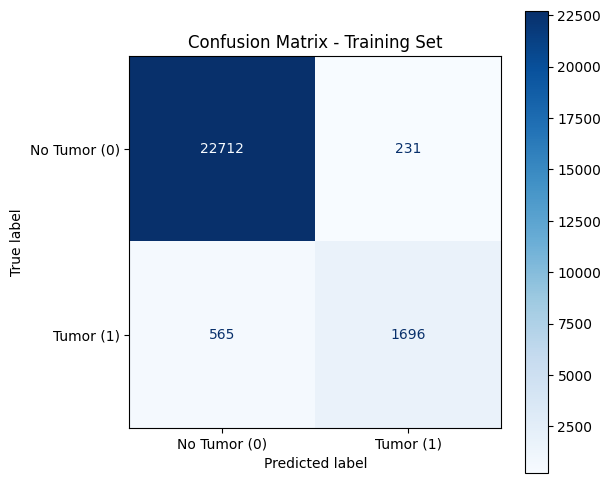

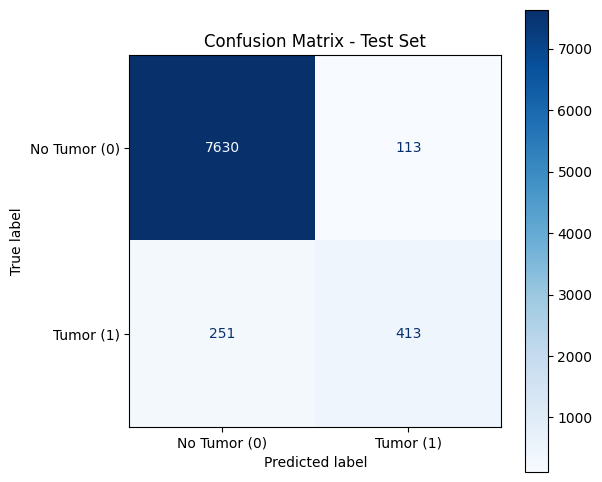

In [15]:
# For training set
cm_train = plot_confusion_matrix(vggnet, X_train_torch, y_train_torch, device, "Training Set")

# For test set
cm_test = plot_confusion_matrix(vggnet, X_test_torch, y_test_torch, device, "Test Set")


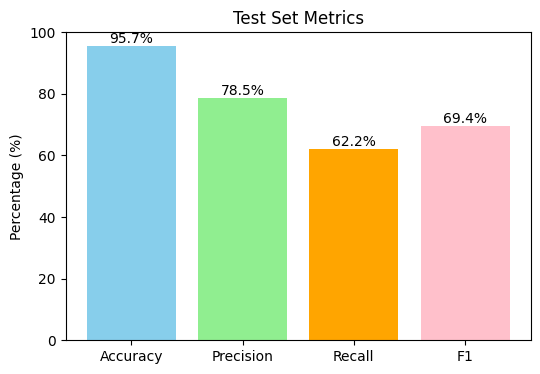

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ---------- 1️⃣ Bar plot of test metrics ----------
metrics = [test_acc, test_precision, test_recall, test_f1]
names = ['Accuracy', 'Precision', 'Recall', 'F1']
plt.figure(figsize=(6,4))
plt.bar(names, metrics, color=['skyblue','lightgreen','orange','pink'])
plt.ylim(0, 100)
plt.ylabel("Percentage (%)")
plt.title("Test Set Metrics")
for i, v in enumerate(metrics):
    plt.text(i, v+1, f"{v:.1f}%", ha='center')
plt.show()

# ---------- 2️⃣ Visualize Sample Predictions ----------
def visualize_samples(X_numpy, y_true, model, n_samples=5, device=device):
    model.eval()
    indices = np.random.choice(len(X_numpy), n_samples, replace=False)
    X_samples = torch.tensor(X_numpy[indices]).unsqueeze(1).repeat(1,3,1,1).float().to(device)
    y_samples = y_true[indices]

    with torch.no_grad():
        outputs = model(X_samples)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()

    plt.figure(figsize=(12,4))
    for i in range(n_samples):
        img = X_numpy[indices[i]].astype(np.uint8)
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Draw bounding box over the patch
        h, w = img.shape
        color = (0,255,0) if preds[i]==y_samples[i] else (0,255,255)  # green correct, yellow wrong
        cv2.rectangle(img_color, (0,0), (w-1,h-1), color, 2)

        # Prediction text
        label = "Tumor" if preds[i]==1 else "No Tumor"
        cv2.putText(img_color, label, (5,20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        plt.subplot(1,n_samples,i+1)
        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

# Visualize 5 samples from Train, Validation, and Tes

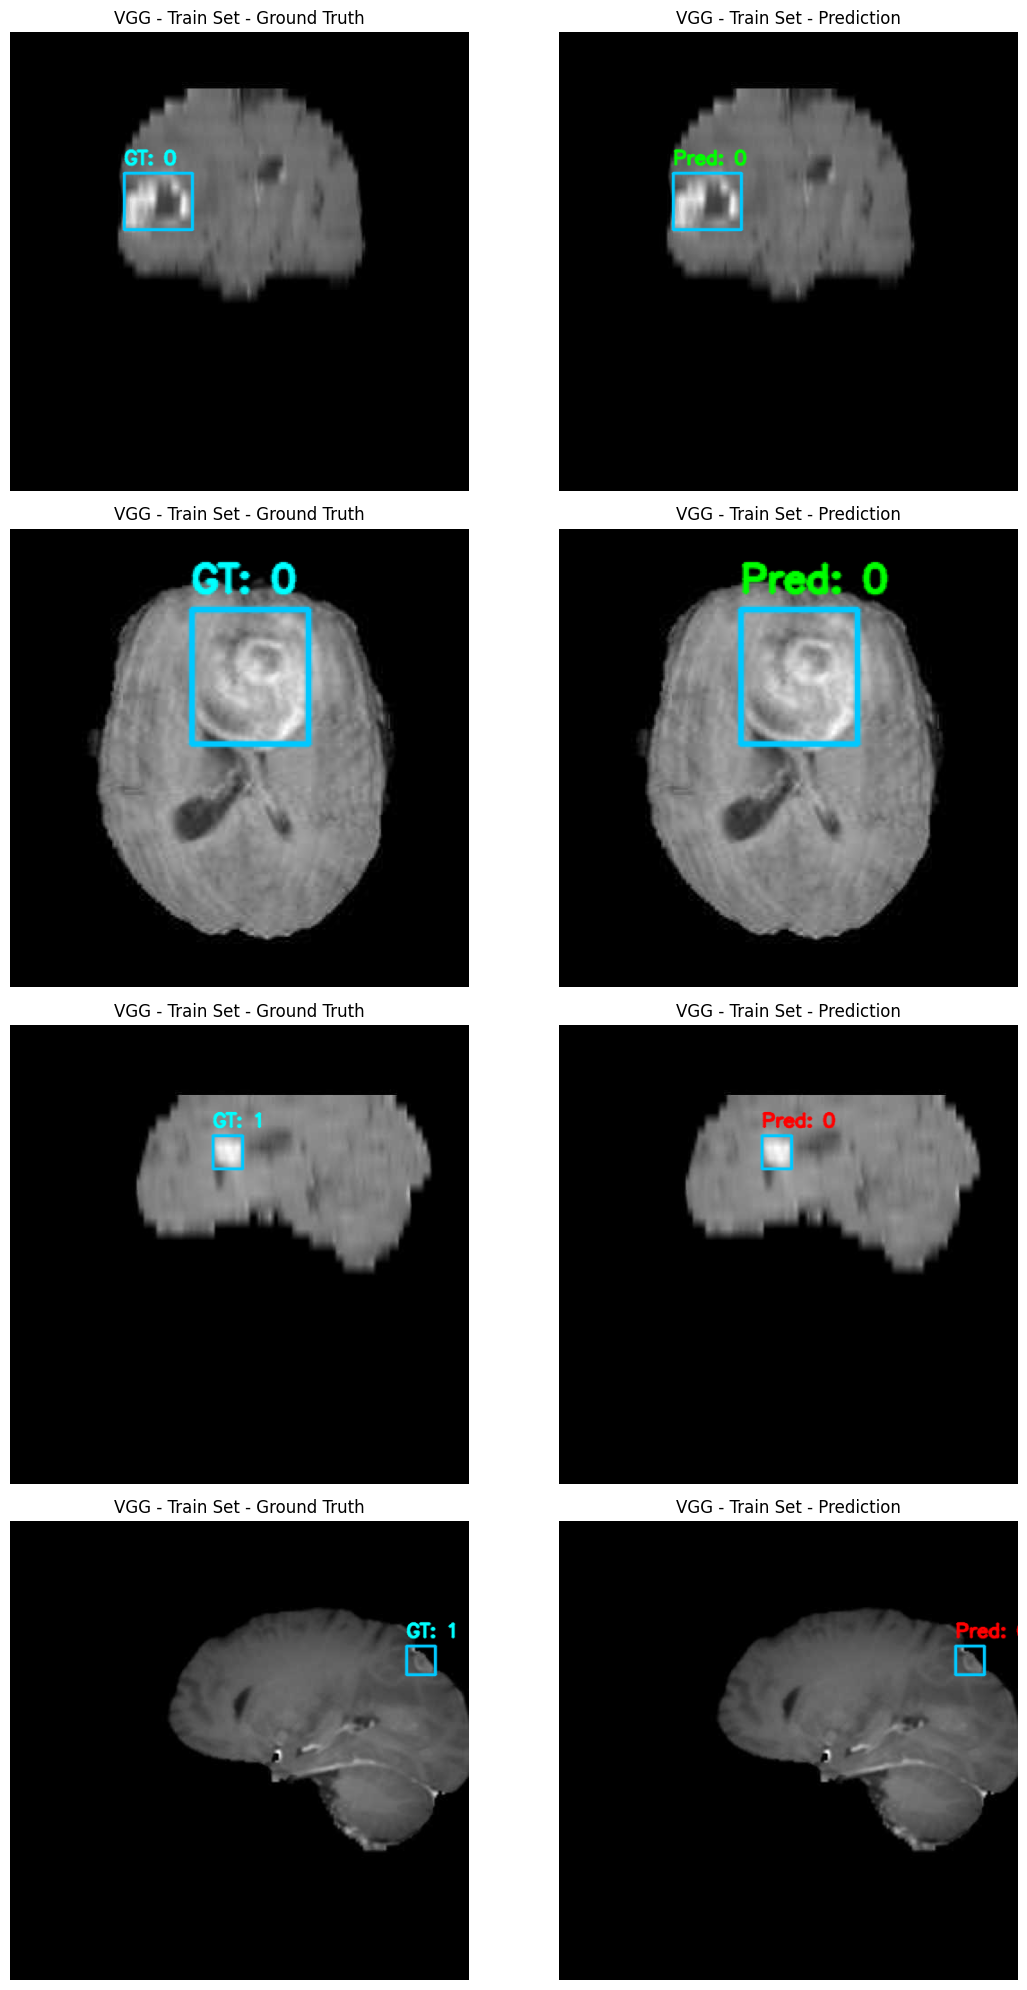

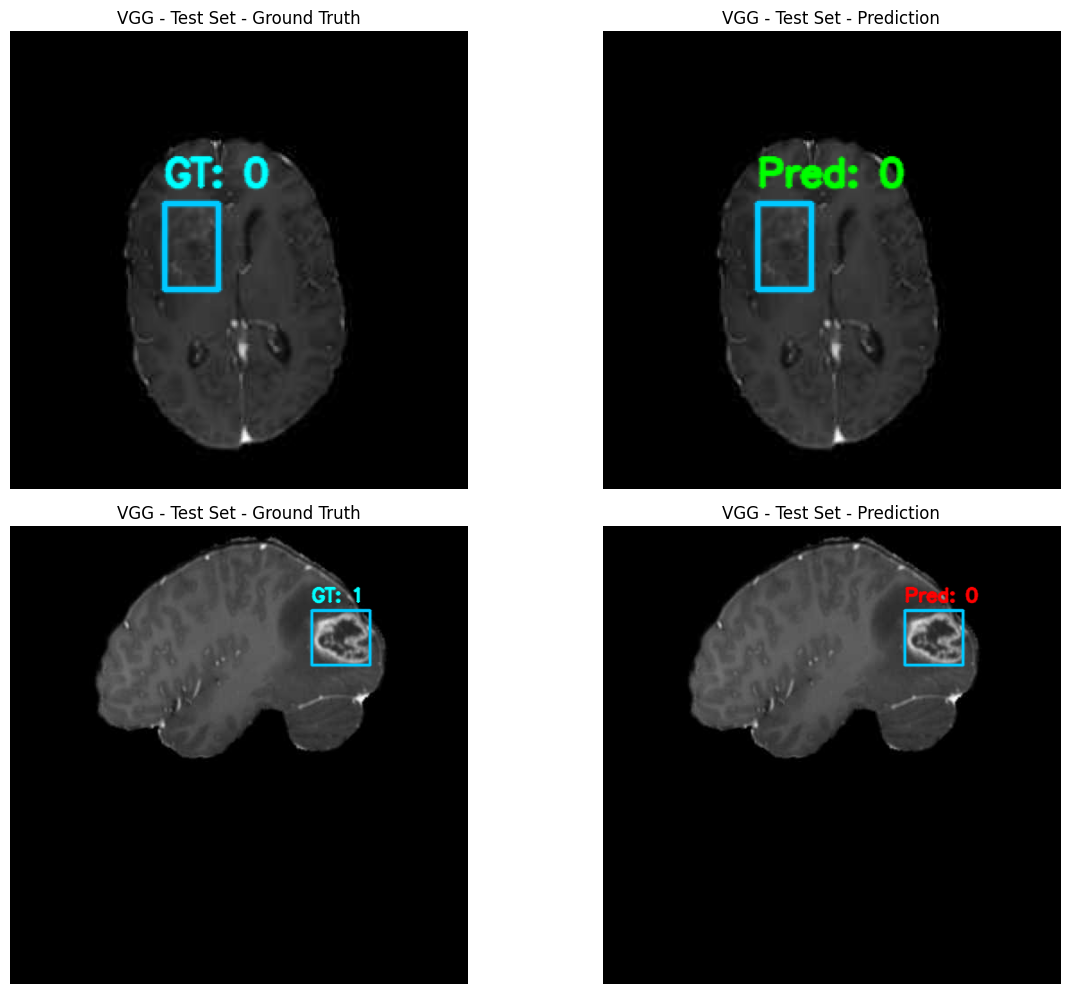

In [12]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

# --- Paths according to your dataset ---
DATA_DIR = "/kaggle/input/braintumor-cv/BrainTumor_cv"

IMG_TRAIN = os.path.join(DATA_DIR, "images", "Train")
IMG_TEST  = os.path.join(DATA_DIR, "images", "Test")
LBL_TRAIN = os.path.join(DATA_DIR, "labels", "Train")
LBL_TEST  = os.path.join(DATA_DIR, "labels", "Test")

# --- Visualization Function for VGGNet ---
def visualize_vgg_samples(img_paths, model, labels_dir, device, num_images=10, dataset_name="Dataset"):
    """
    Visualize a balanced set of MRI images (tumor & non-tumor)
    showing ground truth vs predictions from trained VGGNet.
    """
    model.eval()
    plt.figure(figsize=(12, num_images * 5))
    
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
    
    count = 0
    tumor_count = 0
    non_tumor_count = 0

    for img_path in img_paths:
        if count >= num_images:
            break

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Read label file
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_file = os.path.join(labels_dir, base_name + ".txt")
        if not os.path.exists(label_file):
            continue
        
        with open(label_file, "r") as f:
            line = f.readline().strip()
            parts = line.split()
            label = int(parts[0])  # 0 = non-tumor, 1 = tumor
            x_c, y_c, bw, bh = map(float, parts[1:])
        
        # Balance both classes
        if label == 1 and tumor_count >= num_images // 2:
            continue
        if label == 0 and non_tumor_count >= num_images // 2:
            continue
        
        # Convert normalized bbox to pixel coordinates
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)
        
        # Predict class using trained VGGNet
        img_tensor = preprocess(img).to(device)
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0))
            pred_class = output.argmax(1).item()
        
        # Prepare copies for visualization
        img_left = img.copy()
        img_right = img.copy()
        
        # Draw neat bounding boxes
        box_color = (0, 200, 255)
        cv2.rectangle(img_left, (x1, y1), (x2, y2), box_color, 2, lineType=cv2.LINE_AA)
        cv2.rectangle(img_right, (x1, y1), (x2, y2), box_color, 2, lineType=cv2.LINE_AA)
        
        # Add GT and Pred labels (clean and minimal)
        cv2.putText(img_left, f"GT: {label}", (x1, max(y1-10, 20)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2, cv2.LINE_AA)
        
        color = (0, 255, 0) if pred_class == label else (255, 0, 0)
        cv2.putText(img_right, f"Pred: {pred_class}", (x1, max(y1-10, 20)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)
        
        # Plot both sides
        plt.subplot(num_images, 2, count * 2 + 1)
        plt.imshow(img_left)
        plt.axis("off")
        plt.title(f"{dataset_name} - Ground Truth")
        
        plt.subplot(num_images, 2, count * 2 + 2)
        plt.imshow(img_right)
        plt.axis("off")
        plt.title(f"{dataset_name} - Prediction")
        
        count += 1
        if label == 1:
            tumor_count += 1
        else:
            non_tumor_count += 1
    
    plt.tight_layout()
    plt.show()


# --- Example Usage for VGGNet ---
train_imgs = [os.path.join(IMG_TRAIN, f) for f in os.listdir(IMG_TRAIN) if f.endswith(('.jpg', '.png', '.jpeg'))]
test_imgs  = [os.path.join(IMG_TEST, f) for f in os.listdir(IMG_TEST) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Visualize results from VGGNet model
visualize_vgg_samples(train_imgs, vggnet, LBL_TRAIN, device, num_images=4, dataset_name="VGG - Train Set")
visualize_vgg_samples(test_imgs, vggnet, LBL_TEST, device, num_images=3, dataset_name="VGG - Test Set")


In [13]:
import os

# --- Paths ---
LBL_TEST = "/kaggle/input/braintumor-cv/BrainTumor_cv/labels/Test"

# --- Counter ---
tumor_count = 0
non_tumor_count = 0
total_files = 0

# Loop through all label files
for label_file in os.listdir(LBL_TEST):
    if label_file.endswith(".txt"):
        path = os.path.join(LBL_TEST, label_file)
        with open(path, "r") as f:
            line = f.readline().strip()
            if not line:
                continue
            cls = int(line.split()[0])  # first number is class
            if cls == 1:
                tumor_count += 1
            elif cls == 0:
                non_tumor_count += 1
            total_files += 1

# --- Results ---
print(f"Total label files: {total_files}")
print(f"Tumor (class 1): {tumor_count}")
print(f"No Tumor (class 0): {non_tumor_count}")
print(f"Percentage Tumor: {(tumor_count / total_files) * 100:.2f}%")


Total label files: 223
Tumor (class 1): 81
No Tumor (class 0): 142
Percentage Tumor: 36.32%
